In [1]:
import cv2
import os
import numpy as np

def load_images_from_folders(base_folder):
    images = []
    image_paths = []
    for label in os.listdir(base_folder):
        # if label == 'B' or label == 'C' or label == 'D':
        folder_path = os.path.join(base_folder, label)
        for filename in os.listdir(folder_path):
            if filename[2] == '1':
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (64, 64))
                    # _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
                    images.append(img)
                    image_paths.append(img_path)
    return images, image_paths

folder = 'E:/Data/JHA/CASIA_char_imgs/Gnttest'
images, image_paths = load_images_from_folders(folder)
print(f"Loaded {len(images)} images")


Loaded 4000 images


In [2]:
sift = cv2.SIFT_create()

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

descriptors_list = []
for image in images:
    descriptors = extract_features(image)
    if descriptors is not None:
        descriptors_list.append(descriptors)

print(f"Extracted descriptors for {len(descriptors_list)} images")


Extracted descriptors for 4000 images


In [69]:
from sklearn.cluster import MiniBatchKMeans, KMeans

# 将所有描述子堆叠成一个大的数组
all_descriptors = np.vstack(descriptors_list)
print(f"Stacked all descriptors into array of shape {all_descriptors.shape}")

# 设定聚类数量（根据需要调整）
num_clusters = 10000

kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=200).fit(all_descriptors)
print(f"Clustered descriptors into {num_clusters} clusters")

def create_bovw(descriptors, kmeans):
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

# 为每张图像创建BoVW直方图
bovw_list = [create_bovw(descriptors, kmeans) for descriptors in descriptors_list]

print(f"Created BoVW histograms for {len(bovw_list)} images")


Stacked all descriptors into array of shape (233845, 128)


e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


KeyboardInterrupt: 

Feature matrix shape: (4000, 1000)


e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


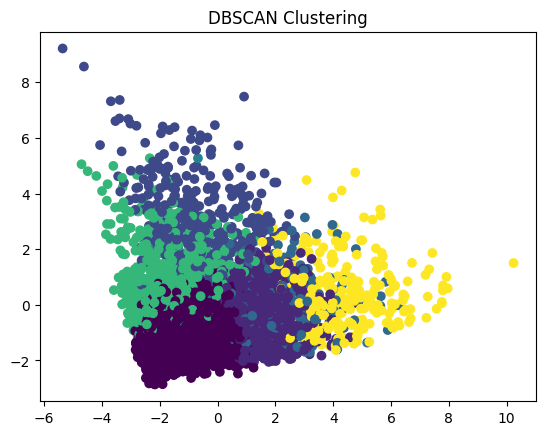

In [67]:
from sklearn.cluster import DBSCAN

# 将BoVW特征向量堆叠成一个大的数组
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt


X = np.array(bovw_list)
print(f"Feature matrix shape: {X.shape}")

# pca = PCA(n_components=100) 
# X = pca.fit_transform(X)

# 使用K-Means进行图像聚类
image_kmeans = MiniBatchKMeans(n_clusters=10, random_state=0).fit(X)
image_labels = image_kmeans.labels_

# # 初始化DBSCAN模型
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 使用DBSCAN进行图像聚类
# dbscan = DBSCAN(eps=12, min_samples=2)

# # 训练模型
# dbscan.fit(X)

# # 获取每个点的簇标签
# image_labels = dbscan.labels_

# # 统计簇标签
# unique_labels = set(image_labels)
# print(f"Number of clusters found: {len(unique_labels) - (1 if -1 in image_labels else 0)}")

# # 找出噪声点的数量
# n_noise = list(image_labels).count(-1)
# print(f"Number of noise points: {n_noise}")

pca = PCA(n_components=2) 
X = pca.fit_transform(X)

# 绘制聚类结果
# plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=image_labels, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=image_labels, cmap='viridis')

plt.title('DBSCAN Clustering')
plt.show()

In [58]:
from collections import Counter

# Step 1: 自动统计路径中的所有类别（即第一级目录）
char_to_labels = {}
for path, label in zip(image_paths, image_labels):
    # 提取第一级目录作为类别，假设路径形式为 'label/img'
    directory = path.split('/')[0]
    if directory not in char_to_labels:
        char_to_labels[directory] = []
    char_to_labels[directory].append(label)

# Step 2: 找到每个目录/类别中出现次数最多的标签
char_to_most_common_label = {
    char: Counter(labels).most_common(1)[0][0] 
    for char, labels in char_to_labels.items()
}

# Step 3: 比较路径中的标签与对应目录的最多标签
num_right_assigned = 0
for path, label in zip(image_paths, image_labels):
    # 提取第一级目录作为类别
    directory = path.split('/')[0]
    print(f"Image: {path} - Cluster: {label}")
    if label == char_to_most_common_label[directory]:
        num_right_assigned += 1

# 计算准确率
print(f"Accuracy: {num_right_assigned / len(image_paths) * 100:.2f}%")


Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00100.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00101.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00102.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00103.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00104.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00105.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00106.png - Cluster: 6
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00107.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00108.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00109.png - Cluster: 6
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00110.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00111.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00112.png - Cluster: 0
Image: E:/Data/JHA/CASIA_char_imgs/Gnttest\006-t\00113.png - Clu

Cluster 0


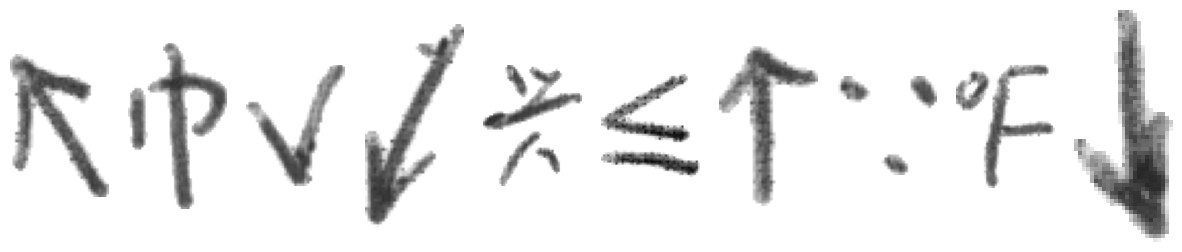

Cluster 1


<Figure size 1500x500 with 0 Axes>

Cluster 2


<Figure size 1500x500 with 0 Axes>

Cluster 3


<Figure size 1500x500 with 0 Axes>

Cluster 4


<Figure size 1500x500 with 0 Axes>

Cluster 5


<Figure size 1500x500 with 0 Axes>

Cluster 6


<Figure size 1500x500 with 0 Axes>

Cluster 7


<Figure size 1500x500 with 0 Axes>

Cluster 8


<Figure size 1500x500 with 0 Axes>

Cluster 9


<Figure size 1500x500 with 0 Axes>

Cluster 10


<Figure size 1500x500 with 0 Axes>

Cluster 11


<Figure size 1500x500 with 0 Axes>

Cluster 12


<Figure size 1500x500 with 0 Axes>

Cluster 13


<Figure size 1500x500 with 0 Axes>

Cluster 14


<Figure size 1500x500 with 0 Axes>

Cluster 15


<Figure size 1500x500 with 0 Axes>

Cluster 16


<Figure size 1500x500 with 0 Axes>

Cluster 17


<Figure size 1500x500 with 0 Axes>

Cluster 18


<Figure size 1500x500 with 0 Axes>

Cluster 19


<Figure size 1500x500 with 0 Axes>

Cluster 20


<Figure size 1500x500 with 0 Axes>

Cluster 21


<Figure size 1500x500 with 0 Axes>

Cluster 22


<Figure size 1500x500 with 0 Axes>

Cluster 23


<Figure size 1500x500 with 0 Axes>

Cluster 24


<Figure size 1500x500 with 0 Axes>

Cluster 25


<Figure size 1500x500 with 0 Axes>

Cluster 26


<Figure size 1500x500 with 0 Axes>

Cluster 27


<Figure size 1500x500 with 0 Axes>

Cluster 28


<Figure size 1500x500 with 0 Axes>

Cluster 29


<Figure size 1500x500 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import random

def plot_images_by_cluster(image_paths, labels, cluster_id):
    cluster_images = [img_path for img_path, label in zip(image_paths, labels) if label == cluster_id]
    num_images = min(len(cluster_images), 10)  # 每个聚类显示最多10张图片
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(cluster_images, num_images)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# 显示每个聚类中的图像
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}")
    plot_images_by_cluster(image_paths, image_labels, cluster_id)
